# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [2]:
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools

import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Useful for connecting to this kernel
%connect_info

{
  "shell_port": 65508,
  "iopub_port": 65509,
  "stdin_port": 65510,
  "control_port": 65512,
  "hb_port": 65511,
  "ip": "127.0.0.1",
  "key": "62510839-4807c6ab6b1c63feb03647ab",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-650b65ad-4761-428b-a209-cf3cb990ea2c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


### Setup params for all runs

Read the parameters file

In [3]:
PARAMETERS_FILENAME = "default.yml"
with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [4]:
current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [5]:
opencl_dir = "../microsim/opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")

## Run OpenCL simulation for multiple repetitions

Code to run the simulation

In [6]:
def run_opencl_model(i, iterations, snapshot_filepath, params, opencl_dir, num_seed_days, use_gpu,
                      store_detailed_counts=True):

    # load snapshot
    snapshot = Snapshot.load_full_snapshot(path=snapshot_filepath)
    
    # set params
    snapshot.update_params(params)
    
    # set the random seed of the model for each repetition, otherwise it is completely deterministic
    snapshot.seed_prngs(i)

    # seed initial infections using GAM initial cases
    data_dir = os.path.join(opencl_dir, "data")
    snapshot.seed_initial_infections(num_seed_days=num_seed_days, data_dir=data_dir)

    # Create a simulator and upload the snapshot data to the OpenCL device
    kernel_dir = os.path.join(opencl_dir, "ramp", "kernels")
    simulator = Simulator(snapshot, kernel_dir=kernel_dir, gpu=use_gpu)
    simulator.upload_all(snapshot.buffers)
    
    print(f"Running simulation {i+1}.")
    summary, final_state = run_headless(simulator, snapshot, iterations, quiet=True,
                                        store_detailed_counts=store_detailed_counts)
    return summary, final_state


Run it:

In [8]:
iterations = 120
repetitions = 10
num_seed_days = 10
use_gpu=False

summaries = []
final_results = []
# Prepare the function arguments as lists for starmap
l_i = [i for i in range(repetitions)]
l_iterations = [iterations] * repetitions
l_snapshot_filepath = [snapshot_filepath] * repetitions
l_params = [params] * repetitions
l_opencl_dir = [opencl_dir] * repetitions
l_num_seed_days = [num_seed_days] * repetitions
l_use_gpu = [use_gpu] * repetitions
results = itertools.starmap( run_opencl_model, zip(
                l_i, l_iterations, l_snapshot_filepath, l_params, l_opencl_dir, l_num_seed_days, l_use_gpu
        ))
summaries = [x[0] for x in results]
final_results = [x[1] for x in results]

Running simulation 1.
Running simulation 2.
Running simulation 3.
Running simulation 4.
Running simulation 5.
Running simulation 6.
Running simulation 7.
Running simulation 8.
Running simulation 9.
Running simulation 10.


## Plot output summary data

### Total counts of disease status

In [9]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

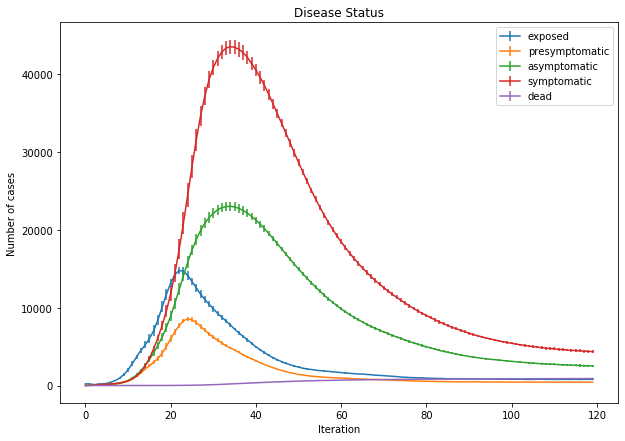

In [10]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [11]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [12]:
   
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

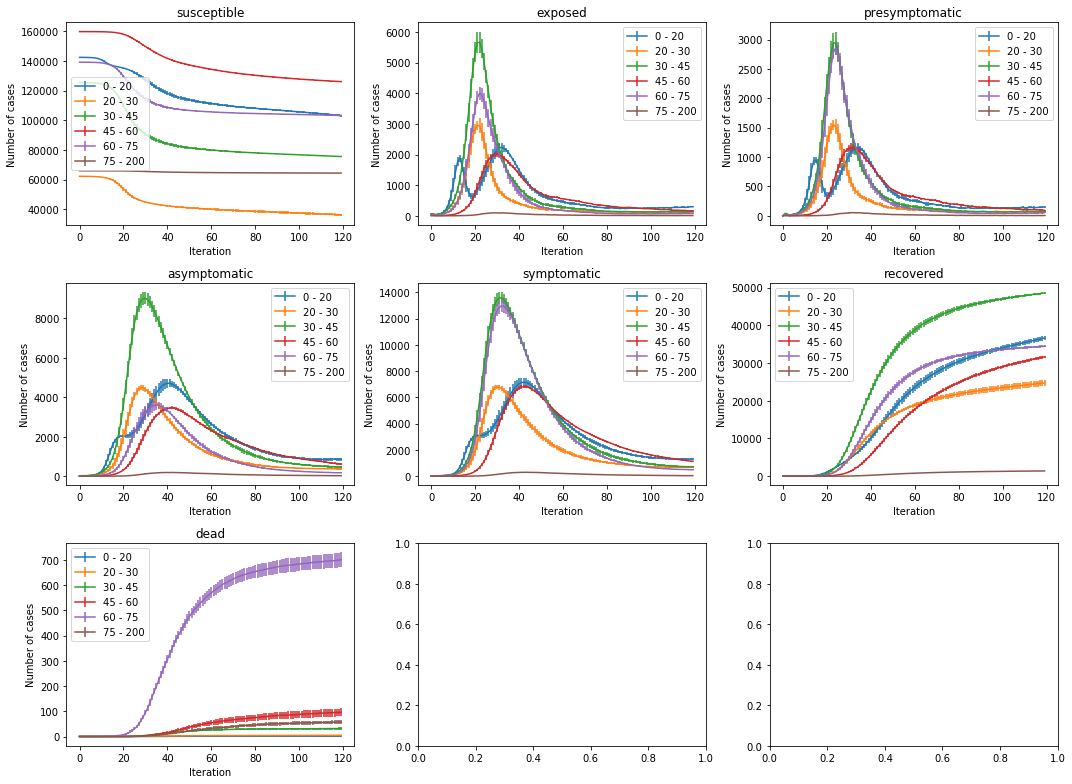

In [13]:
plot_disease_status_by_age(summaries)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


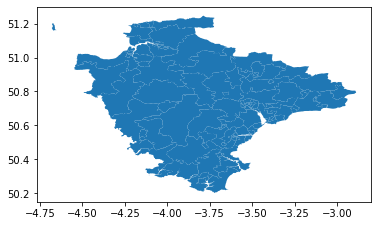

In [14]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [15]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

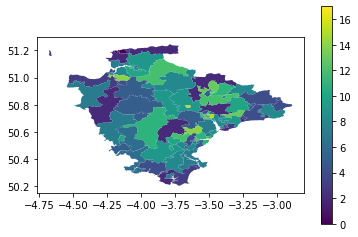

In [16]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)